In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import scienceplots
from scipy.optimize import curve_fit
from typing import Union, Tuple, List, Dict
from nanonets.utils import load_boolean_results, fitness, abundance, get_best_logic_gate, nonlinear_parameter, return_ndr, return_nls

%matplotlib inline
plt.style.use(["science","bright","grid"])

# data_folder = "/home/jonasmensing/bagheera/data/1_funding_period/system_size_scaled/"
data_folder = "/home/j/j_mens07/bagheera/data/1_funding_period/system_size_scaled/"
GATES       = ['AND', 'OR', 'XOR', 'XNOR', 'NAND', 'NOR']
plt.style.use(["science","bright","grid"])

In [4]:
def abundance_multiplot(data: Dict, gates: List[str] = ['AND', 'OR', 'XOR', 'NAND', 'NOR', 'XNOR'], 
    dpi: int = 200, x_limits: List[float] = [0.45, 10], y_limits: List[float] = [1.0, 100], 
    xlabel: str = 'Fitness', ylabel: str = 'Abundance', n_rows=2, n_cols=3, colormap='cividis') -> Tuple[plt.Figure, plt.Axes]:

    cmap    = plt.get_cmap(colormap)
    N_vals  = len(data.keys())

    with plt.style.context(["science","bright","grid"]):
        
        fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, dpi=dpi, layout='constrained')
        fig.set_figwidth(fig.get_figwidth()*1.5)
        fig.set_figheight(fig.get_figheight()*1.1)

        for i, gate in enumerate(gates):
            ax      = axes.flat[i]
            keys    = []
            for j, (key, df) in enumerate(data.items()):
                ax.plot(df[f'{gate} Fitness'], df[f'{gate} Fitness Abundance'], color=cmap(j/N_vals))
                keys.append(key)
            ax.set_xlim(x_limits[0], x_limits[1])
            ax.set_ylim(y_limits[0], y_limits[1])
            ax.set_xscale('log')
            ax.set_yscale('log')
            
            if i >= (n_rows-1)*n_cols:
                ax.set_xlabel(xlabel)
            else:
                ax.set_xticklabels("")

            if i % n_cols == 0:
                ax.set_ylabel(ylabel)
            else:
                ax.set_yticklabels("")

            ax.set_title(gate)

        norm    = mpl.colors.Normalize(vmin=np.min(keys)**2, vmax=np.max(keys)**2)
        cbar    = mpl.cm.ScalarMappable(norm=norm, cmap=colormap)
        fig.colorbar(cbar, ax=axes.ravel(), label='$N_{NP}$')

    return fig, ax

In [5]:
# Parameter
N_min   = 3
N_max   = 13
N_keys  = N_max-N_min+1
N_vals  = [i for i in range(N_min,N_max+1)]
N_e     = 8
delta   = 0.0

data            = load_boolean_results(folder=data_folder, N=N_vals, N_e=N_e, input_cols=['E1','E3'], max_error=np.inf)
fitness_data    = {N : fitness(df=data[N], input_cols=['E1','E3'], delta=delta) for N in N_vals}
abundance_data  = {N : abundance(df=fitness_data[N]) for N in N_vals}
U_on            = [data[N].loc[:,'E1'].max() for N in N_vals]

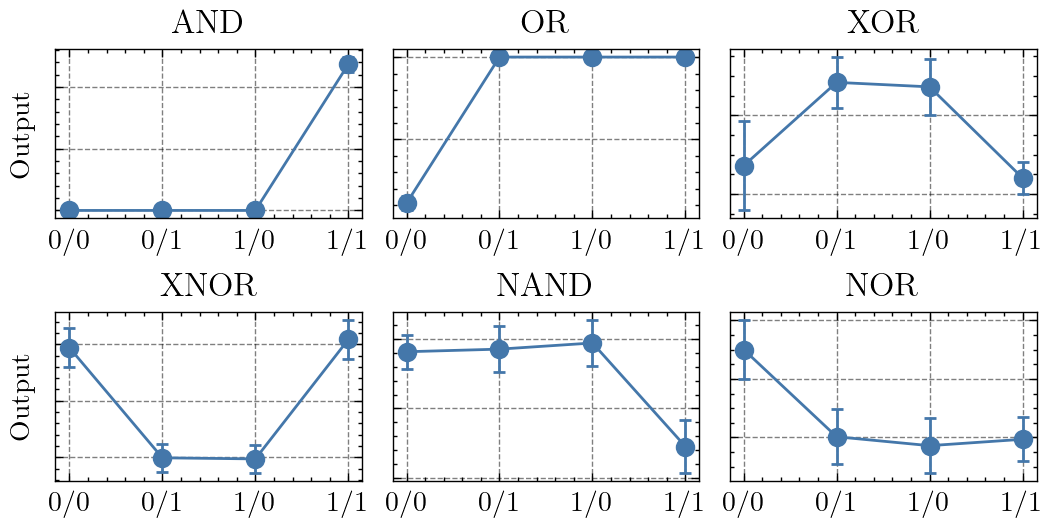

In [33]:
N   = 11
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.5)
for i, gate in enumerate(GATES):
    ax = fig.add_subplot(2,3,i+1)
    best_gate = get_best_logic_gate(data[N], fitness_data[N], gate)
    ax.errorbar([0,1,2,3], best_gate['Observable'].values*1e-6, best_gate['Error'].values*1e-6, marker='o', capsize=2)
    ax.set_xticks([0,1,2,3])
    # ax.set_xticklabels(["$I_{00}$","$I_{01}$","$I_{10}$","$I_{11}$"])
    ax.set_xticklabels(["0/0","0/1","1/0","1/1"])
    ax.set_title(gate)
    ax.set_yticklabels("")
    
    if i % 3 == 0:
        ax.set_ylabel("Output")
        # ax.set_ylabel("$I$ [pA]")

    fig.savefig("plots/system_size_scaled/best_gates.svg", transparent=True)

### Box Plots

In [10]:
fitness_melted = pd.DataFrame()
for gate in GATES:
    df              = pd.DataFrame([fitness_data[key].loc[:,f'{gate} Fitness'].copy().values for key in N_vals],index=np.array(N_vals)**2).T
    df              = df.melt(var_name='$N_{NP}$', value_name='$Fitness$').dropna().reset_index(drop=True)
    df['Gate']      = gate
    fitness_melted  = pd.concat([fitness_melted,df]).reset_index(drop=True)
fitness_melted

,$N_{NP}$,$Fitness$,Gate
0,9,2.691227,AND
1,9,3.741385,AND
2,9,3.985503,AND
3,9,2.714134,AND
4,9,1.952408,AND
...,...,...,...
1302229,169,-52.287037,NOR
1302230,169,-0.814346,NOR
1302231,169,-1.798194,NOR
1302232,169,-1.116070,NOR


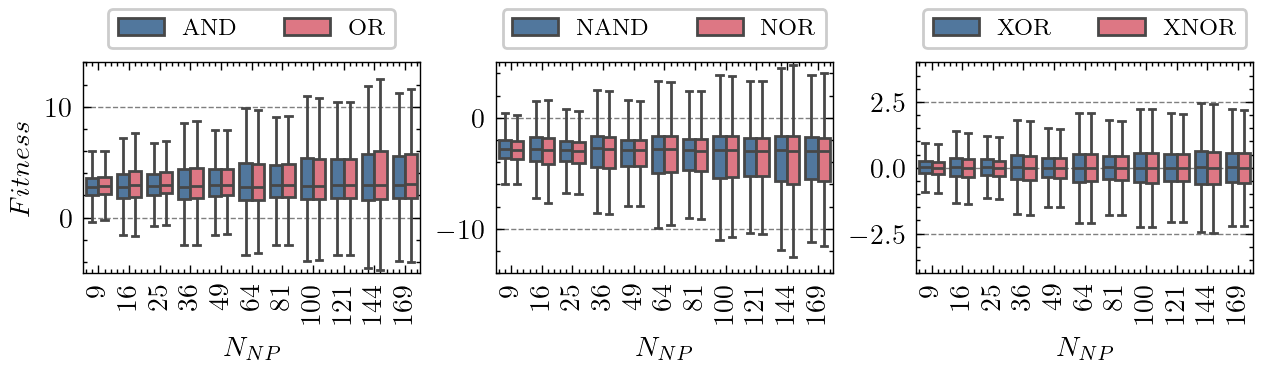

In [19]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figheight(fig.get_figheight()*0.7)
fig.set_figwidth(fig.get_figwidth()*1.8)

for i, g_comb in enumerate([['AND','OR'],['NAND','NOR'],['XOR','XNOR']]):
    ax  = fig.add_subplot(1,3,i+1)
    ax  = sns.boxplot(data=fitness_melted[(fitness_melted['Gate']==g_comb[0])|(fitness_melted['Gate']==g_comb[1])],
                      x='$N_{NP}$', y='$Fitness$', hue='Gate', ax=ax, fliersize=0.)
    leg = ax.legend(loc='center', bbox_to_anchor=(0.5,1.16), ncol=2, fontsize='small')
    leg.set_in_layout(True)
    if i != 0:
        ax.set_ylabel("")
    if i == 0:
        ax.set_ylim(-5,14)
    elif i == 1:
        ax.set_ylim(-14,5)
    else:
        ax.set_ylim(-4,4)
    plt.xticks(rotation=90)

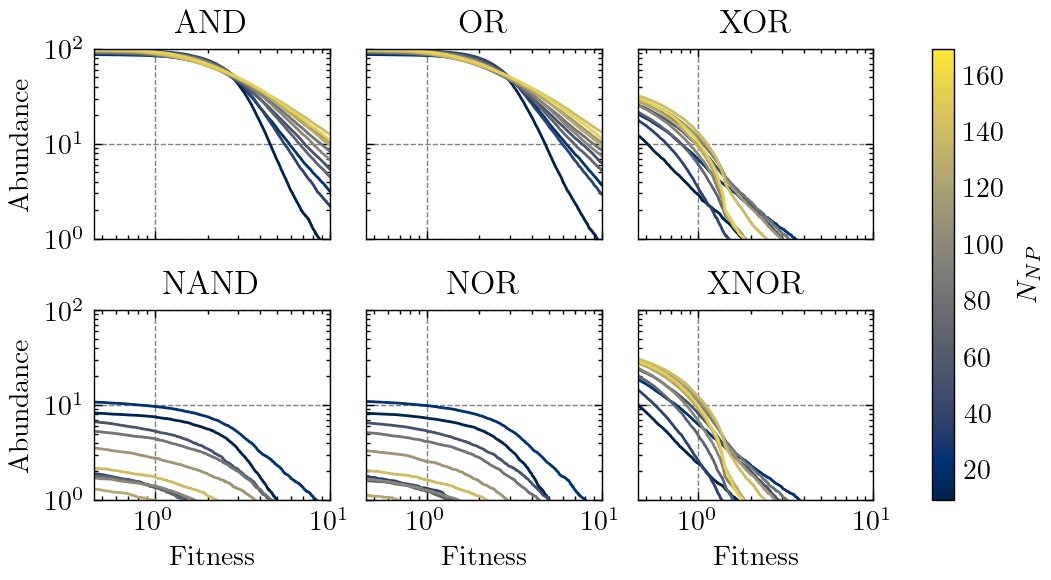

In [12]:
fig, ax = abundance_multiplot(abundance_data)

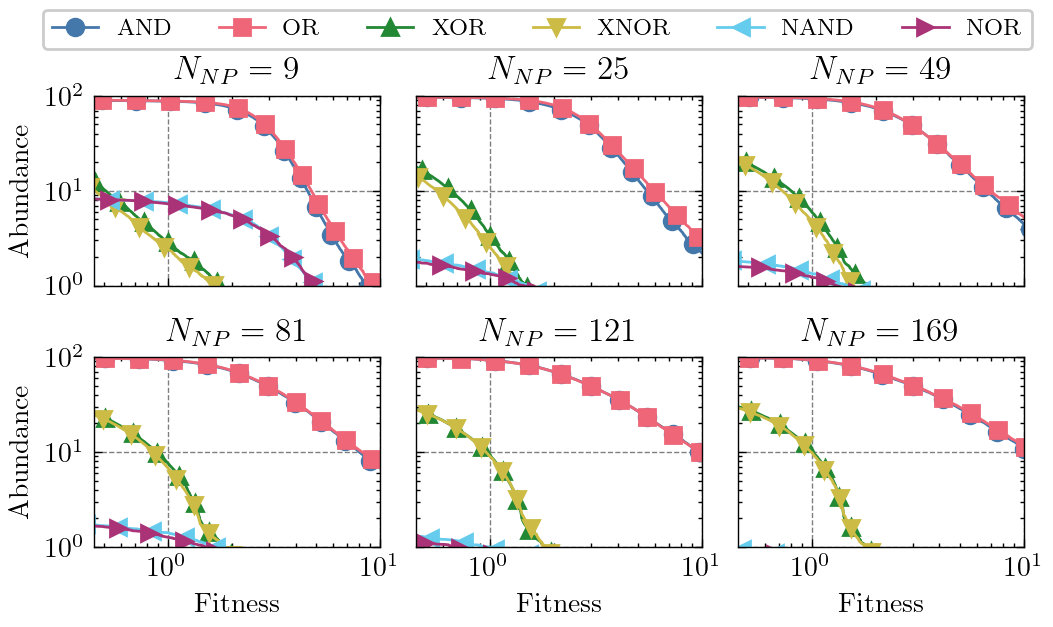

In [14]:
N_plots = [3,5,7,9,11,13]
gates   = ['AND', 'OR', 'XOR', 'XNOR', 'NAND', 'NOR']
marker  = ['o','s','^','v','<','>']
fig     = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.5)
fig.set_figheight(fig.get_figheight()*1.1)

for i, N in enumerate(N_plots):

    ax  = plt.subplot(2,3,i+1)
    for j, gate in enumerate(gates):
        ax.plot(abundance_data[N][f'{gate} Fitness'], abundance_data[N][f'{gate} Fitness Abundance'], label=gate, marker=marker[j % len(marker)], markevery=0.1)
    
    ax.set_xlim(0.45, 10)
    ax.set_ylim(1.0, 100)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title('$N_{NP} = '+f'{N*N}$')
    
    if i % 3 == 0:
        ax.set_ylabel("Abundance")
    else:
        ax.set_yticklabels("")
    if i > 2:
        ax.set_xlabel("Fitness")
    else:
        ax.set_xticklabels("")
    
    if i==0:
        leg = ax.legend(loc='center', bbox_to_anchor=(1.55,1.35), ncol=6, fontsize='small')

leg.set_in_layout(False)
fig.canvas.draw()
leg.set_in_layout(True)
fig.set_layout_engine('none')
# fig.savefig(f"../plots/abundance/scaled_system_size_comparison_delta_{delta}.svg", transparent=True, bbox_inches='tight')
# fig.savefig(f"../plots/abundance/scaled_system_size_comparison_delta_{delta}.pdf", transparent=False, bbox_inches='tight')

/tmp/ipykernel_29338/4191258123.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('cividis')


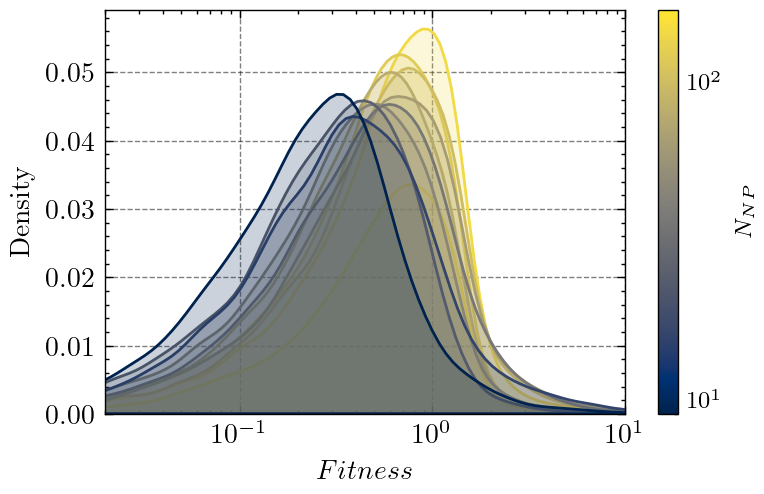

In [15]:
gate = 'XOR'

# Plot
fig = plt.figure(dpi=200)
fig.set_figwidth(fig.get_figwidth()*1.2)
ax  = fig.add_subplot()
ax  = sns.kdeplot(fitness_melted[fitness_melted["Gate"]==gate], x="$Fitness$", ax=ax, hue='$N_{NP}$',
                   log_scale=True, palette='cividis', fill=True, alpha=0.2, legend=False,
                   hue_norm=mpl.colors.LogNorm(N_vals[0]**2, N_vals[-1]**2))
ax.set_xlim(2e-2, 1e1)

# Legend
cmap = mpl.cm.get_cmap('cividis')
norm = mpl.colors.LogNorm(vmin=N_vals[0]**2, vmax=N_vals[-1]**2)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('$N_{NP}$', fontsize='small')
cbar.ax.tick_params(labelsize='small')

## Nonlinear Parameter

In [16]:
# Current Relations
n_bootstrap = 100
params      = {N : nonlinear_parameter(data[N], on_state=U_on[i], n_bootstrap=n_bootstrap) for i, N in enumerate(N_vals)}

# NDR / NLS
bins    = 'fd'
Q_ndr   = []
Q_nls   = []
for i in range(n_bootstrap): 

    Q_ndr_l =   np.array([return_ndr(params[N][i]['Ml']) for N in N_vals])
    Q_ndr_r =   np.array([return_ndr(params[N][i]['Mr']) for N in N_vals])
    Q_ndr.append((Q_ndr_l + Q_ndr_r) / 2)

    Q_nls.append(np.array([return_nls(df=params[N][i], bins=bins) for N in N_vals]))

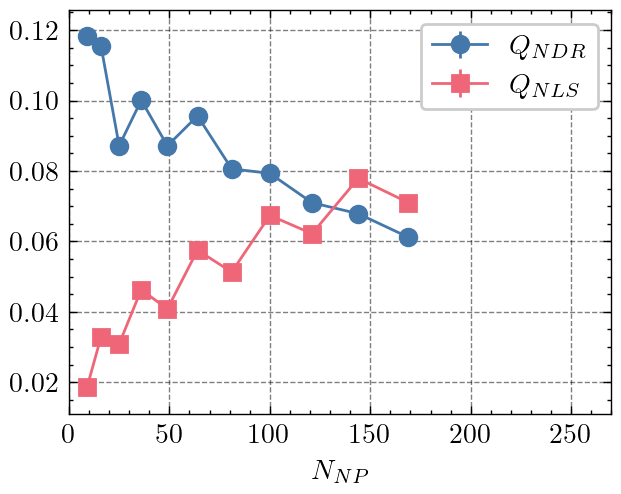

In [17]:
with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()
    
    ax.errorbar(np.array(N_vals)**2, np.mean(Q_ndr,axis=0), 1.96*np.std(Q_ndr,axis=0), marker='o', label='$Q_{NDR}$')
    ax.errorbar(np.array(N_vals)**2, np.mean(Q_nls,axis=0), 1.96*np.std(Q_ndr,axis=0), marker='s', label='$Q_{NLS}$')

    ax.set_xlabel('$N_{NP}$')
    ax.legend(loc='upper right')
    ax.set_xlim(0,270)
    # ax.set_ylim(0.1,0.5)

# fig.savefig("../plots/scaled_nonlinearity_vs_system_size_scaled.svg", transparent=True, bbox_inches='tight')
# fig.savefig("../plots/scaled_nonlinearity_vs_system_size_scaled.pdf", transparent=False, bbox_inches='tight')

In [34]:
max_jumps_portion   = [100*((data[N]['Jumps']==1e7).sum() / len(data[N])) for N in N_vals]
rel_error_dist      = [100*np.abs(data[N]['Error'].values / data[N]['Observable'].values) for N in N_vals]

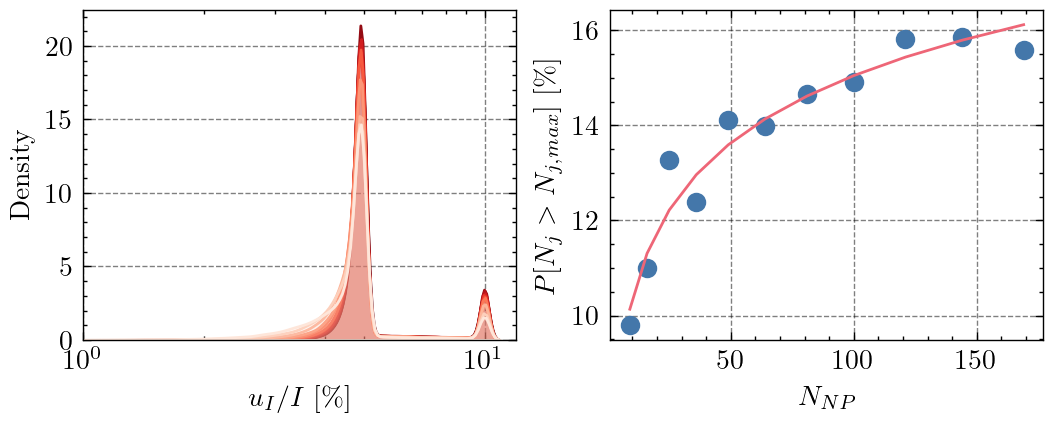

In [35]:
def lin_func(x, a, b):
    return a*x + b
def log_func(x, a, b):
    return a * np.log(x) + b

with plt.style.context(["science","bright","grid"]):

    cmap    = plt.get_cmap('Reds')
    fig     = plt.figure(dpi=200, layout='constrained')
    ax1     = fig.add_subplot(1,2,1)
    ax2     = fig.add_subplot(1,2,2)
    fig.set_figwidth(fig.get_figwidth()*1.5)
    fig.set_figheight(fig.get_figheight()*0.8)

    for i, arr in enumerate(rel_error_dist[::-1]):
        arr1            = arr.copy()
        arr1[arr1 > 10] = 10
        ax1             = sns.kdeplot(arr1, ax=ax1, color=cmap((len(rel_error_dist)-i)/len(rel_error_dist)), 
                                      fill=True, alpha=0.1, log_scale=True)

    ax1.set_xlim(1,12)
    ax1.set_xlabel('$u_I / I$ [\%]')

    x       = np.array(N_vals)**2
    y       = max_jumps_portion
    p, _    = curve_fit(log_func, x, y)
    ax2.plot(x, y, 'o')
    ax2.plot(x, log_func(x,*p), '-')
    ax2.set_xlabel('$N_{NP}$')
    ax2.set_ylabel('$P[N_{j} > N_{j,max}]$ [\%]')
    # ax2.set_xlim(0,270)

    # fig.savefig("../plots/data_quality_vs_system_size.svg", transparent=True, bbox_inches='tight')
    # fig.savefig("../plots/data_quality_vs_system_size.pdf", transparent=False, bbox_inches='tight')